<h1><center>
<b>DCGAN (Deep Convolutional GAN)<b/>
</center></h1>
<h2> Importing Libraries<h2>

In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import h5py, os
import numpy as np
from torch.utils.data import DataLoader
import torchvision.utils as vutils
from functions import transforms as T
from functions.subsample import MaskFunc
from scipy.io import loadmat
from matplotlib import pyplot as plt
import csv
import time
from skimage.measure import compare_ssim 

# Set random seed for reproducibility
manualSeed = 42
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  42


In [20]:
# Root directory for dataset
wp='PC'
if wp=='PC':
    data_path_train = '/data/local/NC2019MRI/train'
    data_path_val = '/data/local/NC2019MRI/train'
    
    model_dir='/home/students/lxr863/NC_Final_Assessment/fastMRI/models/'
    model_path='/home/students/lxr863/NC_Final_Assessment/fastMRI/models/DCGAN_CNN.pth'
else:
    data_path_train = 'C:/Users/Ersalina/NC_Final_Assignment/fastMRI/NC2019MRI/train'
    data_path_val = 'C:/Users/Ersalina/NC_Final_Assignment/fastMRI/NC2019MRI/train'
    
    model_dir='C:/Users/Ersalina/NC_Final_Assignment/fastMRI/NC2019MRI/models'
    model_path='C:/Users/Ersalina/NC_Final_Assignment/fastMRI/NC2019MRI/models/3LC_CNN.pth'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 2

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 320

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 32

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
def crop_img(data, width, height):
    return T.center_crop(data,[width,height])

def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction, use_seed, cplx):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction
        self.use_seed = use_seed
        self.cplx=cplx

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction, self.use_seed, self.cplx)

def get_epoch_batch(subject_id, acc, center_fract, use_seed=True, cplx=False):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    Cplx=cplx
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    rawdata=crop_img(rawdata,320,320)
            
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    #print('raw',(rawdata).shape)
    #slice_kspace2=T.to_tensor_mod(rawdata)
    
    slice_kspace_abs=torch.log(T.complex_abs(slice_kspace) + 1e-9)
    # apply random mask
    shape = np.array(slice_kspace.shape)
    #shape2 = np.array(slice_kspace2.shape)
    mask_func = MaskFunc(center_fractions=[center_fract], accelerations=[acc])
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
    #mask2 = mask_func(shape2, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)
    #masked_kspace2 = torch.where(mask2 == 0, torch.Tensor([0]), slice_kspace2)
    masks = mask.repeat(S, Ny, 1, ps)
    masked_kspace_abs=torch.log(T.complex_abs(masked_kspace) + 1e-9)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)
    #print(slice_kspace.shape)
    #print(img_gt.shape)
    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_gt, img_und, rawdata_und = img_gt/norm, img_und/norm, masked_kspace/norm
       
    img_gt=T.center_crop(T.complex_abs(img_gt),[320,320])
    img_und=T.center_crop(T.complex_abs(img_und),[320,320])
    #print('img_gt:',img_gt.shape)
    #return img_gt.squeeze(0), img_und.squeeze(0), rawdata_und.squeeze(0), masks.squeeze(0), norm
    if not Cplx:
        return img_und, img_gt # x is the undersampled image y is the ground truth
    else:
        return masked_kspace2, slice_kspace2

def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
    
        for fname in sorted(os.listdir(which_data_path)):
            
            subject_data_path = os.path.join(which_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(5, num_slice)]
    
    return data_list    

def show_img(data, slice_nums, train_num, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[train_num,num], cmap=cmap)
        plt.axis('off')
        
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )
        
def train_onestep(model, lossfcn, optimiser):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  # check whether a GPU is available
#device='cuda:0'
print(device)

cuda:0


## Load data

In [21]:
num_files=len(os.listdir(data_path_train))
index=(np.arange(num_files))

np.random.seed(42)
np.random.shuffle(index)
# we will split the train and validate data by 80:20
train_index=np.sort(index[:int(num_files*0.8)])
validate_index=np.sort(index[int(num_files*0.8):])
print('train:',train_index)
print('validate:',validate_index)

#print((index))
idn=[]
# create dictionary contains the information about the traindata and validation data from train dataset
data_list = {}
data_list['train']=[]
data_list['validate']=[]
for idx,fname in enumerate(sorted(os.listdir(data_path_train))): 
    subject_data_path = os.path.join(data_path_train, fname)         
    if not os.path.isfile(subject_data_path): continue         
    with h5py.File(subject_data_path, 'r') as data:
            num_slice = data['kspace'].shape[0]
    if len(np.where(train_index==idx)[0]):
        data_list['train']+=[(fname,subject_data_path,slice) for slice in range(5,num_slice)]
        #data_list['train']+=[(fname,subject_data_path,slice) for slice in range(5,num_slice)]
        #print('train_filename:',fname)
    else:
        data_list['validate']+=[(fname,subject_data_path,slice) for slice in range(5,num_slice)]
        #data_list['validate']+=[(fname,subject_data_path,slice) for slice in range(5,num_slice)]
        #print('validate_filename:',fname)
        
#print(len(data_list))
#print(len(data_list['train']))
#print(len(data_list['validate']))
#print((data_list['validate']))

#data_list = load_data_path(data_path_train, data_path_val) # first load all file names, paths and slices.
#print(data_list)
acc = 8
cen_fract = 0.04
seed = False # random masks for each slice 
num_workers = 0 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
cplx = False # complex k-space data
# create data loader for training set. It applies same to validation set as well
train_dataset = MRIDataset(data_list['train'], acceleration=acc, center_fraction=cen_fract, use_seed=seed, cplx=cplx)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=num_workers) 

for iteration, sample in enumerate(train_loader):

    x, y = sample # x is the undersampled image y is the ground truth image

    print(x.shape)
    print(y.shape)

    if iteration >= 0: break  # show 4 random slices

train: [ 0  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 22 24 25 26 27 28 30
 31 32 33 34 35 36 38 39 40 41 42 44 45 46 47 48 49 50 53 54 55 56 57 58
 59 62 63 64 66 67 68 69]
validate: [ 1  2 14 20 21 23 29 37 43 51 52 60 61 65]
torch.Size([2, 1, 320, 320])
torch.Size([2, 1, 320, 320])


In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# UNet network components
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

In [8]:
# Generator Code uses UNet structure

class Generator(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(Generator, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [9]:
# Create the generator
netG = Generator(1,1).to(device)

'''
# Handle multi-gpu if desired
if (device.type == 'cuda:0') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
'''
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netG.apply(weights_init)

# Print the model
print(netG)

ig=torch.randn(batch_size,nc,320,320,device=device)
print('ig:',ig.shape)
print(netG(ig).shape)

Generator(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, m

In [10]:
def nG(isize,kernels,stride,padding):
    imstage=np.full(len(kernels),0)
    for i,kernel in enumerate(kernels):
        imstage[i]=(isize-1)*stride[i]-2*padding[i]+1*(kernels[i]-1)+0+1
        print("i= %2d, k=%3d istage=%4d"%(i,kernel,imstage[i]))
        isize=imstage[i]
#nG(1,[4,3,3,3,3],[2,3,3,3,3],[0,0,0,0,2])      
nG(1,[4,3,3,3,3],[2,3,3,3,3],[0,0,0,0,2])

i=  0, k=  4 istage=   4
i=  1, k=  3 istage=  12
i=  2, k=  3 istage=  36
i=  3, k=  3 istage= 108
i=  4, k=  3 istage= 320


In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 3, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 3, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 3, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 0, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
'''
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
'''
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

inp=torch.randn(1,1,320,320).to(device)
print(netD(inp).shape)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(3, 3), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)
torch.Size([1, 1, 1, 1])


In [13]:
def sdf(isize,kernels,stride,paddings):
    imstage=np.full(len(kernels),0)
    for i,kernel in enumerate(kernels):
        imstage[i]=((isize-kernels[i]+(2*paddings[i]))/stride[i])+1
        print("i= %2d, k=%3d istage=%4d"%(i,kernel,imstage[i]))
        isize=imstage[i]
        
sdf(320,[4,4,4,4,4],[3,3,3,2,2],[1,1,1,0,0])

i=  0, k=  4 istage= 107
i=  1, k=  4 istage=  36
i=  2, k=  4 istage=  12
i=  3, k=  4 istage=   5
i=  4, k=  4 istage=   1


In [14]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

<h2> Train the Network <h2/>

In [22]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        x_data,y_data=data                         # undersampled and ground truth images
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = y_data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        
        '''
        print('rcpu',real_cpu.shape)
        print('bsize',b_size)
        print('lab',label)
        
        print('Dout',netD(real_cpu).shape)
        print('Doutv',output.shape)
        '''
        
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        #noise = torch.randn(b_size, nz, 1, 1, device=device)
        noise = x_data.to(device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        #print((fake).shape)
        #break
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        '''
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        '''
        
        iters += 1
        #print('ydat:',y_data.shape)
        #print('fake:',fake.shape)
        #break
        

Starting Training Loop...
[0/5][0/850]	Loss_D: 1.3640	Loss_G: 5.9653	D(x): 0.7497	D(G(z)): 0.6453 / 0.0315
[0/5][50/850]	Loss_D: 3.2860	Loss_G: 0.8010	D(x): 0.0723	D(G(z)): 0.4036 / 0.5329
[0/5][100/850]	Loss_D: 2.3435	Loss_G: 2.0760	D(x): 0.7562	D(G(z)): 0.8142 / 0.2090
[0/5][150/850]	Loss_D: 1.9376	Loss_G: 0.4061	D(x): 0.4275	D(G(z)): 0.1783 / 0.7026
[0/5][200/850]	Loss_D: 2.3239	Loss_G: 1.7269	D(x): 0.7950	D(G(z)): 0.7405 / 0.1796
[0/5][250/850]	Loss_D: 1.0265	Loss_G: 1.6156	D(x): 0.5785	D(G(z)): 0.3765 / 0.2085
[0/5][300/850]	Loss_D: 2.1317	Loss_G: 0.4121	D(x): 0.1527	D(G(z)): 0.1839 / 0.6631
[0/5][350/850]	Loss_D: 2.0186	Loss_G: 0.6838	D(x): 0.2668	D(G(z)): 0.3818 / 0.5083
[0/5][400/850]	Loss_D: 1.6771	Loss_G: 1.6813	D(x): 0.5765	D(G(z)): 0.5875 / 0.2014
[0/5][450/850]	Loss_D: 1.7835	Loss_G: 1.2372	D(x): 0.4871	D(G(z)): 0.5554 / 0.2941
[0/5][500/850]	Loss_D: 1.5939	Loss_G: 0.7342	D(x): 0.4166	D(G(z)): 0.4455 / 0.4941
[0/5][550/850]	Loss_D: 0.8939	Loss_G: 1.2964	D(x): 0.6123	D(G(z)

<h2> Results <h2/>

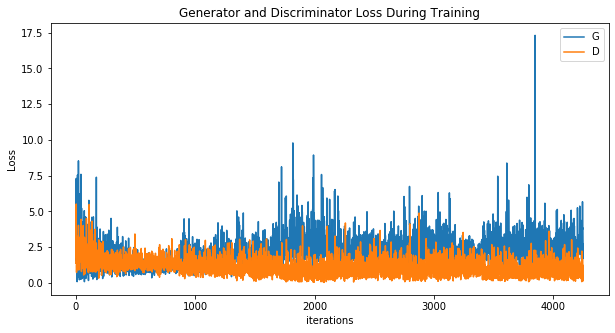

In [23]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

<h2> Real vs Fake <h2/>

torch.Size([1, 1, 320, 320])
torch.Size([1, 1, 320, 320])


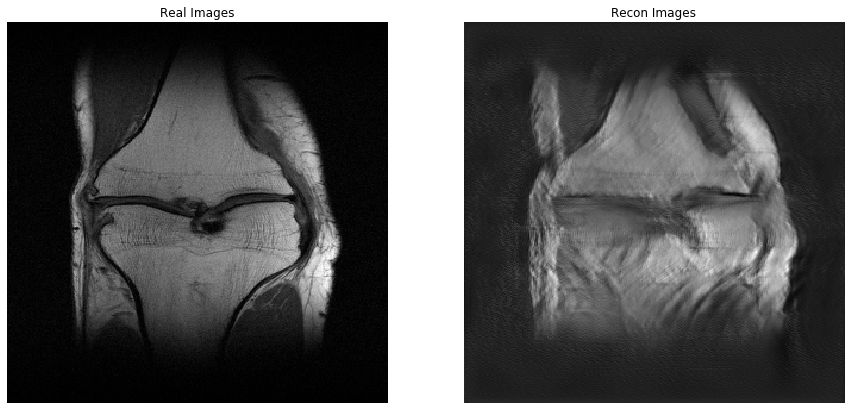

In [24]:
real_batch = next(iter(train_loader))

print(y_data.shape)
print(fake.shape)
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(y_data.to(device), padding=5, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Recon Images")
plt.imshow(np.transpose(vutils.make_grid(torch.Tensor.cpu(fake).detach(), padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
'''
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

print(real_batch[0].shape)
print(img_list[-1].shape)
'''
plt.show()